In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/XiaoXiang_project')

Mounted at /content/gdrive


# 加载数据及数据预处理

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import re
import jieba

# def find_chinese(file):
#   pattern = re.compile(r'[^\u4e00-\u9fa5 \t]')
#   chinese_txt = re.sub(pattern,'',file)
#   return chinese_txt

def remove_noise(document):
  noise_pattern = re.compile("|".join(["http\S+", ":http\S+", "ｗｗｗ.+?\t",'\d+\@\S+']))
  clean_text = re.sub(noise_pattern, "", document)
  return clean_text.strip()

def preprocess_text(content_lines):
  segs=jieba.lcut(content_lines)
  segs = list(filter(lambda x:len(x)>1, segs)) #没有解析出来的新闻过滤掉
  segs = list(filter(lambda x:x not in stopwords, segs)) #把停用词过滤掉
  return ' '.join(segs)


# i = 0
i = 1
if i == 0:
  train_df = pd.read_csv('./data/train.csv', sep="###__###", header=None, names=['ID', 'Age', 'Gender', 'Education', 'Query_List'])
  test_df = pd.read_csv('./data/test.csv', sep="###__###", header=None, names=['ID', 'Query_List'])
  stopwords_df = pd.read_table('./data/cn_stopwords.txt', header=None, names=['StopWords'])
  stopwords = stopwords_df['StopWords'].values

  train_df['Query_List'] = train_df['Query_List'].apply(remove_noise)
  train_df['Query_List'] = train_df['Query_List'].apply(preprocess_text)

  train_df.to_csv('./data/train_cutwords.csv', index=None)

elif i == 1:
  train_df = pd.read_csv('./data/train_cutwords.csv')

train_df.head()

,ID,Age,Gender,Education,Query_List
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和 双沟 女生 中财网 首页 财经 周公 解梦 大全 查询 2345 曹云金 再讽 郭德纲...
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,广州 厨宝 烤箱 世情 人情 雨送 黄昏 花易落 风干 泪痕 厦门 酒店用品 批发市场 不想...
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,钻石 之泪 耳机 盘锦 沈阳 旅顺 公交 辽宁 阜新 车牌 baidu k715 k716 ...
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,受欢迎 狗狗 排行榜 场景 范例 三维 绘图 软件 酸奶 一起 壮观 衣服 网站 动漫 绘图...
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,干槽症 自愈 太太 万岁 舒心 美国 干槽症 眼皮 下面 一直 怎么回事 麦当劳 旋风 勺子...


In [3]:
'''
  先跑通代码，删除标签为0的数据，后续进行填充
'''

train_df = train_df[~(train_df['Age']==0)]
train_df = train_df[~(train_df['Gender']==0)]
train_df = train_df[~(train_df['Education']==0)]

train_df['Age'] = train_df['Age'] - 1
train_df['Gender'] = train_df['Gender'] - 1
train_df['Education'] = train_df['Education'] - 1

train_df['Query_List'] = train_df['Query_List'].apply(lambda x: x.split(' '))
train_df = train_df.reset_index(drop=True)


train_df.head()

,ID,Age,Gender,Education,Query_List
0,22DD920316420BE2DF8D6EE651BA174B,0,0,3,"[柔和, 双沟, 女生, 中财网, 首页, 财经, 周公, 解梦, 大全, 查询, 2345..."
1,43CC3AF5A8D6430A3B572337A889AFE4,1,0,2,"[广州, 厨宝, 烤箱, 世情, 人情, 雨送, 黄昏, 花易落, 风干, 泪痕, 厦门, ..."
2,6931EFC26D229CCFCEA125D3F3C21E57,3,1,2,"[受欢迎, 狗狗, 排行榜, 场景, 范例, 三维, 绘图, 软件, 酸奶, 一起, 壮观,..."
3,E780470C3BB0D340334BD08CDCC3C71A,1,1,3,"[干槽症, 自愈, 太太, 万岁, 舒心, 美国, 干槽症, 眼皮, 下面, 一直, 怎么回..."
4,0D58894CD481D4B3039000661665C0DB,2,1,2,"[貔貅, 饲育, 指南, 韩姨, 贵阳, 古琴, 洛基, 风速, 英美, 店主, 好吃, 重..."


# 定义一些要用到的函数

In [4]:
from collections import Counter


def build_vocab(train_data, vocab_file, vocab_size=5000):
  '''
    根据训练集构建词汇表，并保存为txt格式文件
  '''
  all_data = []
  for i in range(train_data.shape[0]):
    all_data.extend(train_data['Query_List'][i])
  counter = Counter(all_data)

  # print(len(counter))


  # 取出现最多的前n个词
  # vocab_size = 5000

  count_pairs = counter.most_common(vocab_size - 1)
  words, _ = list(zip(*count_pairs))
  
  # 添加一个 <PAD> 来将所有文本pad为同一长度
  words = ['<PAD>'] + list(words)
  open(vocab_file, mode='w', encoding='utf-8', errors='ignore').write('\n'.join(words) + '\n')

def read_vocab(vocab_file):
  '''
    读取词汇表，构建词语-->ID编号的映射
  '''
  with open(vocab_file, 'r') as f:
    words = [_.strip() for _ in f.readlines()]
  word_to_id = dict(zip(words, range(len(words))))
  return words, word_to_id

def encode_cate(content, words):
  '''将文字转换为id表示的内容'''
  return [(words[x] if x in words else 40000) for x in content]

def encode_sentences(contents, words):
  '''将文字转换为id表示的内容'''
  return [encode_cate(x,words) for x in contents]


# 定义网络结构

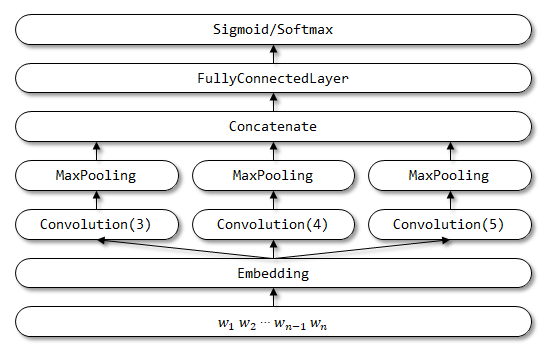

In [5]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalAveragePooling1D, Concatenate, Dropout

class TextCNN(object):
  def __init__(self, maxlen, max_features, embedding_dims, class_num, last_activation='softmax'):
    self.maxlen = maxlen
    self.max_features = max_features
    self.embedding_dims = embedding_dims
    self.class_num = class_num
    self.last_activation = last_activation

  def get_model(self):
    input = Input((self.maxlen,))
    embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(input)
    convs = []
    for kernel_size in [3, 4, 5]:
      c = Conv1D(128, kernel_size, activation='relu')(embedding)
      c = GlobalAveragePooling1D()(c)
      convs.append(c)

    # c = Conv1D(128, kernel_size=3, activation='relu')(embedding)
    # c = GlobalAveragePooling1D()(c)
    # convs.append(c)
    # c = Conv1D(256, kernel_size=4, activation='relu')(embedding)
    # c = GlobalAveragePooling1D()(c)
    # convs.append(c)
    # c = Conv1D(512, kernel_size=5, activation='relu')(embedding)
    # c = GlobalAveragePooling1D()(c)
    # convs.append(c)

    x = Concatenate()(convs)

    output = Dense(self.class_num, activation=self.last_activation)(x)
    model = Model(inputs=input, outputs=output)
    return model

# 数据处理与训练

In [9]:
from tensorflow.keras.preprocessing import sequence
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# 路径设置
vocab_file = './vocab/vocab.txt'

# 词汇量
vocab_size = 40000

# 神经网络配置
max_features = 40001
maxlen = 100
batch_size = 64
embedding_dims = 50
epochs = 8
class_num = 6

print('正在进行数据处理。。。。')
if not os.path.exists(vocab_file):
  build_vocab(train_df, vocab_file, vocab_size=vocab_size)

words, word_to_id = read_vocab(vocab_file)

x = train_df['Query_List'].to_list()
y_age = train_df['Age'].to_list()

data = list(zip(x,y_age))
del x, y_age

# 乱序
random.shuffle(data)
# 切分训练集和测试集
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
# 对文本进行编码
x_train = encode_sentences([content[0] for content in train_data], word_to_id)
y_train = to_categorical([_[1] for _ in train_data], class_num)
x_test = encode_sentences([content[0] for content in test_data], word_to_id)
y_test = to_categorical([_[1] for _ in test_data], class_num)


print('对序列做padding，保证是 samples*timestep 的维度')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

print('构建模型...')
model = TextCNN(maxlen, max_features, embedding_dims, class_num).get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('训练...')
# 设定callbacks回调函数
filepath = './model/weights.{epoch:02d}-{val_loss:.2f}.hdf5'

my_callbacks = [
    ModelCheckpoint(filepath, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]

# fit拟合数据
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

print('对测试集预测...')
result = model.predict(x_test)

正在进行数据处理。。。。
对序列做padding，保证是 samples*timestep 的维度
x_train shape: (70793, 100)
y_train shape: (70793, 6)
x_test shape: (17699, 100)
y_test shape: (17699, 6)
构建模型...
训练...
Epoch 1/8
1107/1107 [==============================] - 38s 33ms/step - loss: 1.2172 - accuracy: 0.5018 - val_loss: 1.0579 - val_accuracy: 0.5717

Epoch 00001: saving model to ./model/weights.01-1.06.hdf5
Epoch 2/8
1107/1107 [==============================] - 36s 33ms/step - loss: 0.8718 - accuracy: 0.6677 - val_loss: 1.1183 - val_accuracy: 0.5513

Epoch 00002: saving model to ./model/weights.02-1.12.hdf5
Epoch 3/8
1107/1107 [==============================] - 37s 33ms/step - loss: 0.6576 - accuracy: 0.7591 - val_loss: 1.2906 - val_accuracy: 0.5260

Epoch 00003: saving model to ./model/weights.03-1.29.hdf5
对测试集预测...
